## Imports

In [2]:
# data pre-processing
import pickle
import numpy as np
import pandas as pd
from epiweeks import Week
from datetime import timedelta
import os

# pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.diagnostic import normal_ad
from scipy import stats
from sklearn import metrics

# custom evaluation functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", context='poster')
plt.rcParams['figure.figsize'] = [20,10]
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR


## Add New Data

In [2]:
# add new week of data

new_data = {'Surveillance Week':[47],
            'A(H1N1)pdm09':[119],
            'A(H3N2)':	[2214],
            'A(Unsubtyped)':[5424],
            'Influenza B':[16],
            'Percent Positive A':[23.1],
            'Percent Positive B':[0.0]}

In [3]:
# add new data

new_data_df = pd.DataFrame.from_dict(new_data)
new_data_df = new_data_df.iloc[:,0:5]

# add year
for i in range(len(new_data_df)):
    if int(new_data_df['Surveillance Week'][i]) >= 35 & int(new_data_df['Surveillance Week'][i]) <= 53:
        new_data_df['Year'] = "2022"
    else:
        new_data_df['Year'] = "2023"

# get total cases
sum_list = new_data_df.columns[1:5]
new_data_df['Total Cases'] = new_data_df[sum_list].sum(axis=1)

# get epiweek
new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].astype(int).astype(str)
new_data_df['Surveillance Week'] = new_data_df['Surveillance Week'].str.pad(2, fillchar='0')
new_data_df['Year'] = new_data_df['Year'].astype(int).astype(str)
new_data_df['Epiweek'] = new_data_df['Year'] + new_data_df['Surveillance Week'].astype(str)

# get date
new_data_df['Week Ending'] = new_data_df['Epiweek'].apply(lambda x: Week.fromstring(x).enddate())
new_data_df['Week Ending'] = pd.to_datetime(new_data_df['Week Ending'], format="%Y-%m-%d")

# save to 
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu.pkl", "rb" ))
df_flu.loc[len(df_flu.index)] = np.nan
df_flu['Week Ending'].iloc[-1] = df_flu['Week Ending'].iloc[-2] + timedelta(weeks=1)
df_flu['Week Ending'].iloc[-1]
pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu.pkl", "wb" ))
df_flu = df_flu[['Week Ending', 'Total Cases']]
df_flu = df_flu.set_index('Week Ending')
pickle.dump(df_flu, open(r"..\data\flu_cases\df_flu_total.pkl", "wb" ))


# TO UPDATE ALL DATAFRAMES - RE-RUN _2_Feature_Engineering Notebook

## Load Data

In [3]:
# basic time series with total cases
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))
df_flu_subtypes = pickle.load(open(r"..\data\flu_cases\df_flu.pkl", "rb" ))

# full feature set - full time series, pre-COVID, post-COVID
df_features = pickle.load(open(r"..\data\df_flu_all_features.pkl", "rb" ))
df_features_pre_COVID = pickle.load(open(r"..\data\df_flu_pre_COVID_all_features.pkl", "rb" ))
df_features_COVID = pickle.load(open(r"..\data\df_flu_COVID_all_features.pkl", "rb" ))

# to get column names for individual feature sets
df_health_indicators = pickle.load(open(r"..\data\health_indicators\df_health_indicators.pkl", "rb" ))
df_air_travel = pickle.load(open(r"..\data\mobility\df_air_travel.pkl", "rb" ))
df_urban_transit = pickle.load(open(r"..\data\mobility\df_urban_transit.pkl", "rb" ))
df_flu_symptoms = pickle.load(open(r"..\data\google_trend\df_flu_symptoms.pkl", "rb" ))
df_COVID_terms = pickle.load(open(r"..\data\google_trend\df_COVID_terms.pkl", "rb" ))

## Train / Test Split

In [4]:
# get data
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))
df = df_time_features.drop(columns=['year','month'])

# get dataframe for plotting dates
df_to_plot = df.dropna()

# last row to make prediction on
df_to_predict = df.iloc[-1,5:]
df_to_predict = pd.DataFrame(df_to_predict).T
df_to_plot

# drop nulls and date to prepare for modelling
df = df.drop(columns='Week Ending').dropna()

# train/test split
train_size = int(len(df) *.7)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(df)]

train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

time_test = df_to_plot[train_size:len(df)]['Week Ending']
time_train = df_to_plot[0:train_size]['Week Ending']

cat_feats = train_X.dtypes[(train_X.dtypes == 'object')].index.tolist()
num_feats = list(train_X.drop(columns=cat_feats).columns)

In [5]:
df.columns

Index(['y1', 'y2', 'y3', 'y4', 'season', 't - 1', 't - 2', 't - 3', 't - 4',
       't - 5', 't - 6', 't - 7', 'this week last year',
       'two-week moving average', 'expanding mean'],
      dtype='object')

In [ ]:
df = df.rename(columns={'t - 1':'previous'})

# Modelling

In [7]:
# set up pipeline
numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
(categorical_transform, cat_feats),
(numeric_transform, num_feats),   
remainder='drop')

mid_model = GradientBoostingRegressor(loss="squared_error", random_state=2023)

pipeline_mid = Pipeline(steps=[('preprocessing', ct), 
  ('mid_model', mid_model),
  ])

In [13]:
crossval_count = 1000
min_size = 100
max_random = len(train_X) - (min_size)

crossval_resids = []

for b in range(crossval_count):
    start, end = [min_size*i+x for i, x in enumerate(sorted([np.random.randint(max_random) for y in range(2)]))]

    # fit and predict
    test_index = np.random.randint(0,97,1000)

    pipeline_mid.fit(train_X[start:end], train_y[start:end]['y1'])
    pred = pipeline_mid.predict(pd.DataFrame(test_X.iloc[test_index[b]]).T)

    # calcuate residual
    crossval_resids.append(pred - test_y.iloc[test_index[b]]['y1'])
    
bsed_residuals = sorted(crossval_resids)

In [14]:
from itertools import chain

bsed_residuals = list(chain.from_iterable(bsed_residuals))

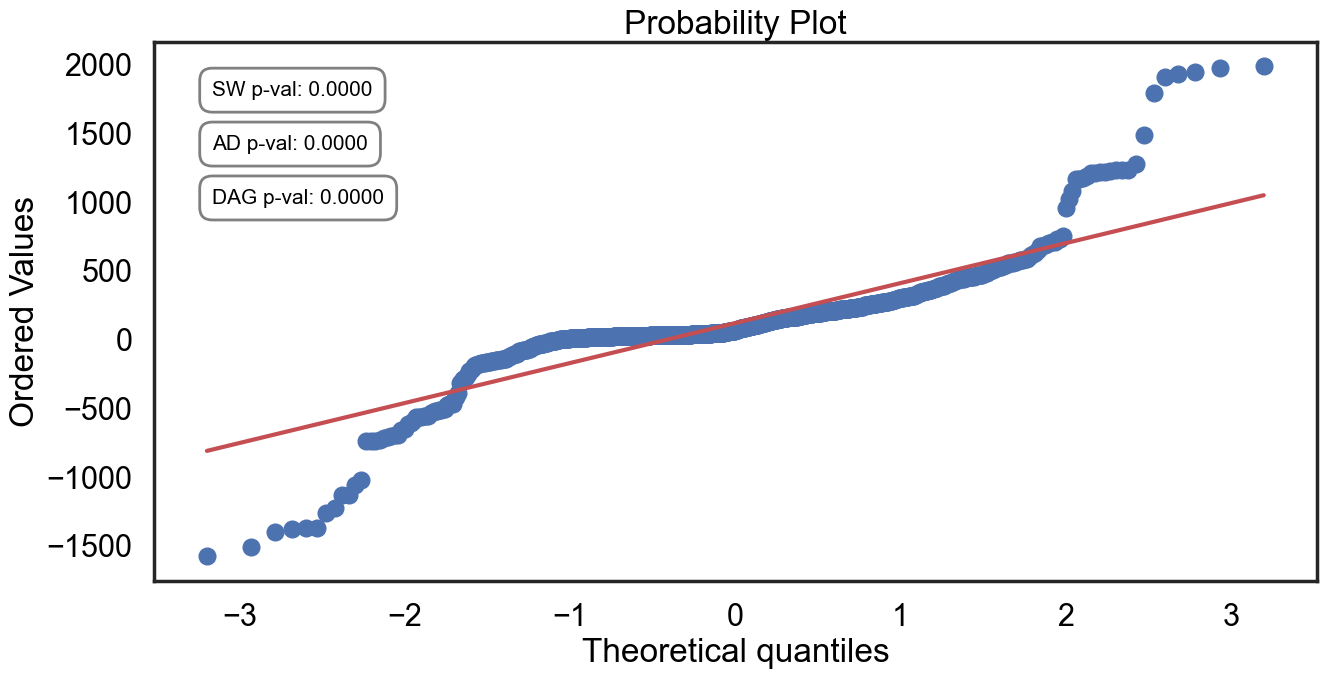

In [15]:
sw_result = stats.shapiro(bsed_residuals)
ad_result = normal_ad(np.array(bsed_residuals), axis=0)
dag_result = stats.normaltest(bsed_residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(15,7))
res = stats.probplot(bsed_residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [16]:
bs_stds=[]
last_std = None

for i in range(10000):
    samples = [bsed_residuals[np.random.randint(len(bsed_residuals))] for x in range(len(bsed_residuals))]
    bs_stds.append(np.std(samples))
    if i%500 == 0 and i!=0:
        if i == 500:
            last_std = np.median(bs_stds)
        else:
            current_std = np.median(bs_stds)
            if abs(current_std - last_std) < last_std*0.00001:
                print("Early Stopping Iteration: {}".format(i))
                break
            else:
                last_std = np.median(bs_stds)        
    
bs_std = np.median(bs_stds)
print("Median of Bootstrapped STD's: {:.4f}".format(bs_std))

bs_band_size = 1.96*bs_std

Early Stopping Iteration: 5000
Median of Bootstrapped STD's: 327.9824


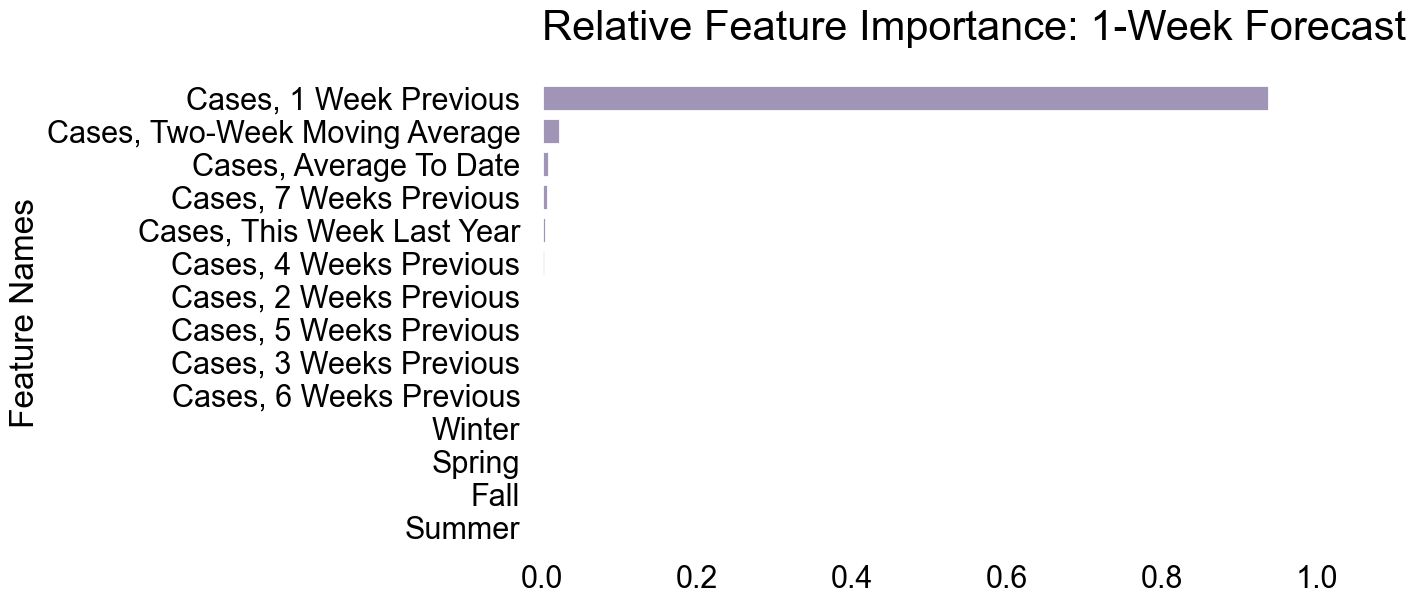

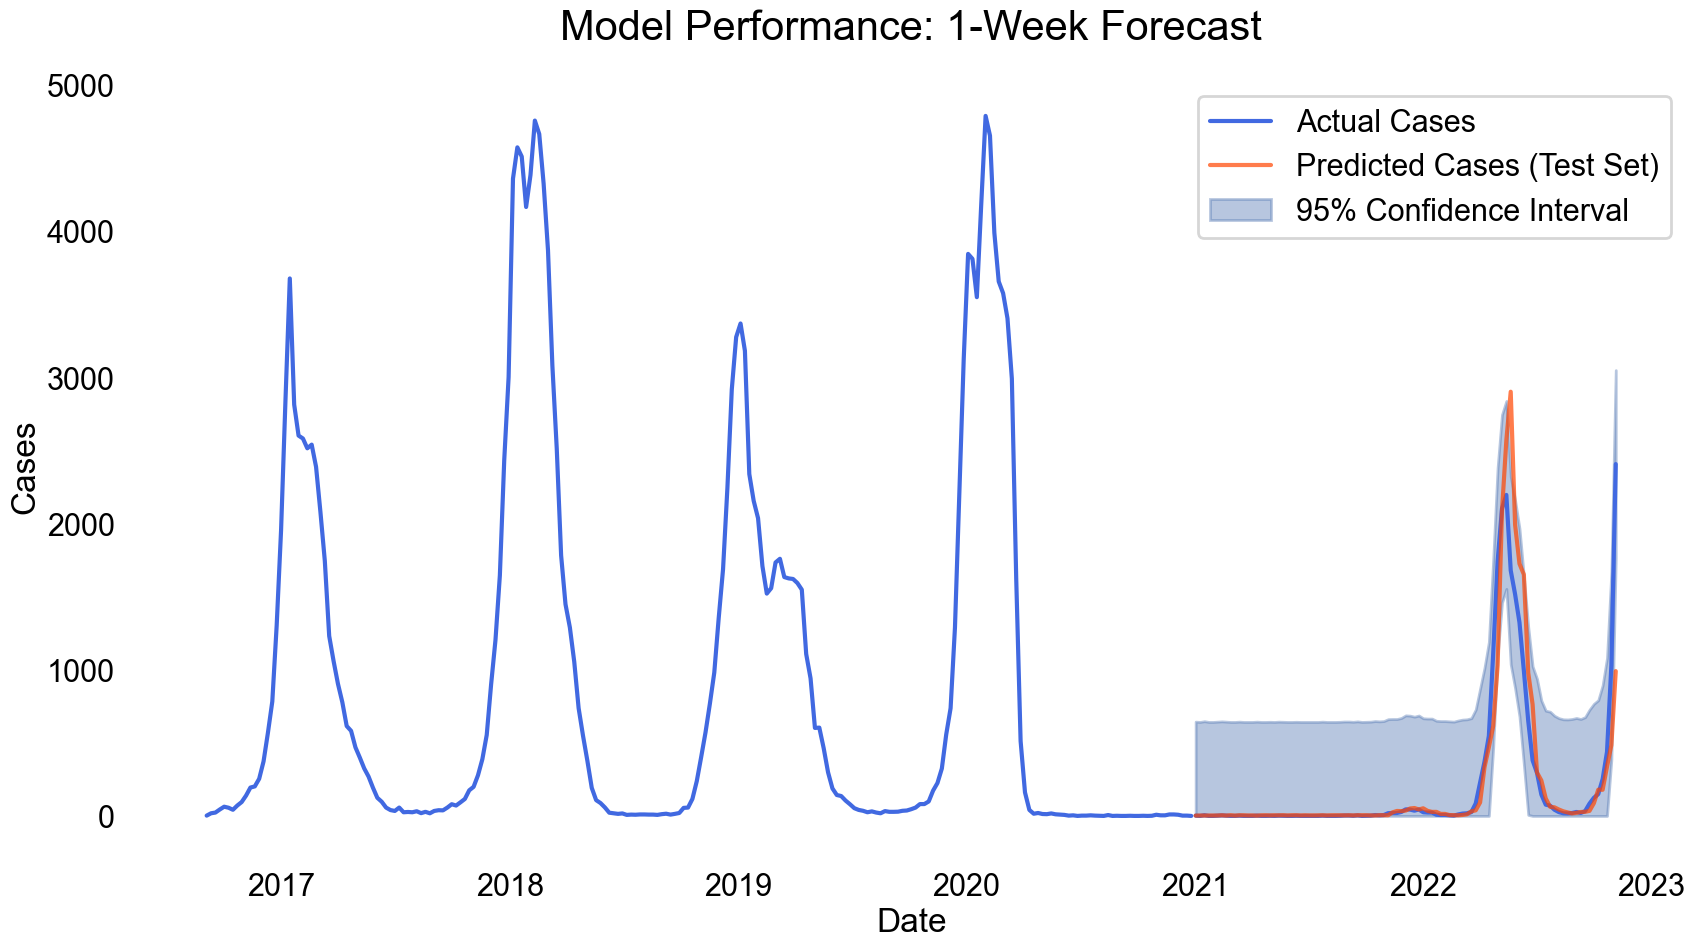

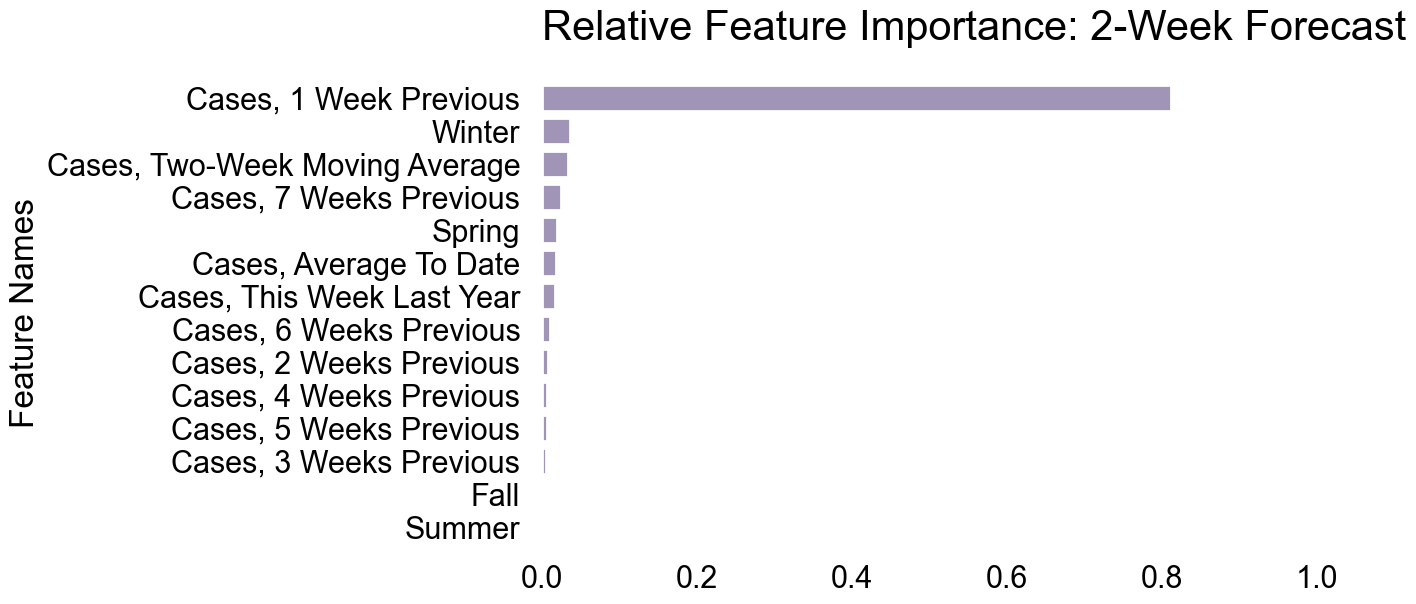

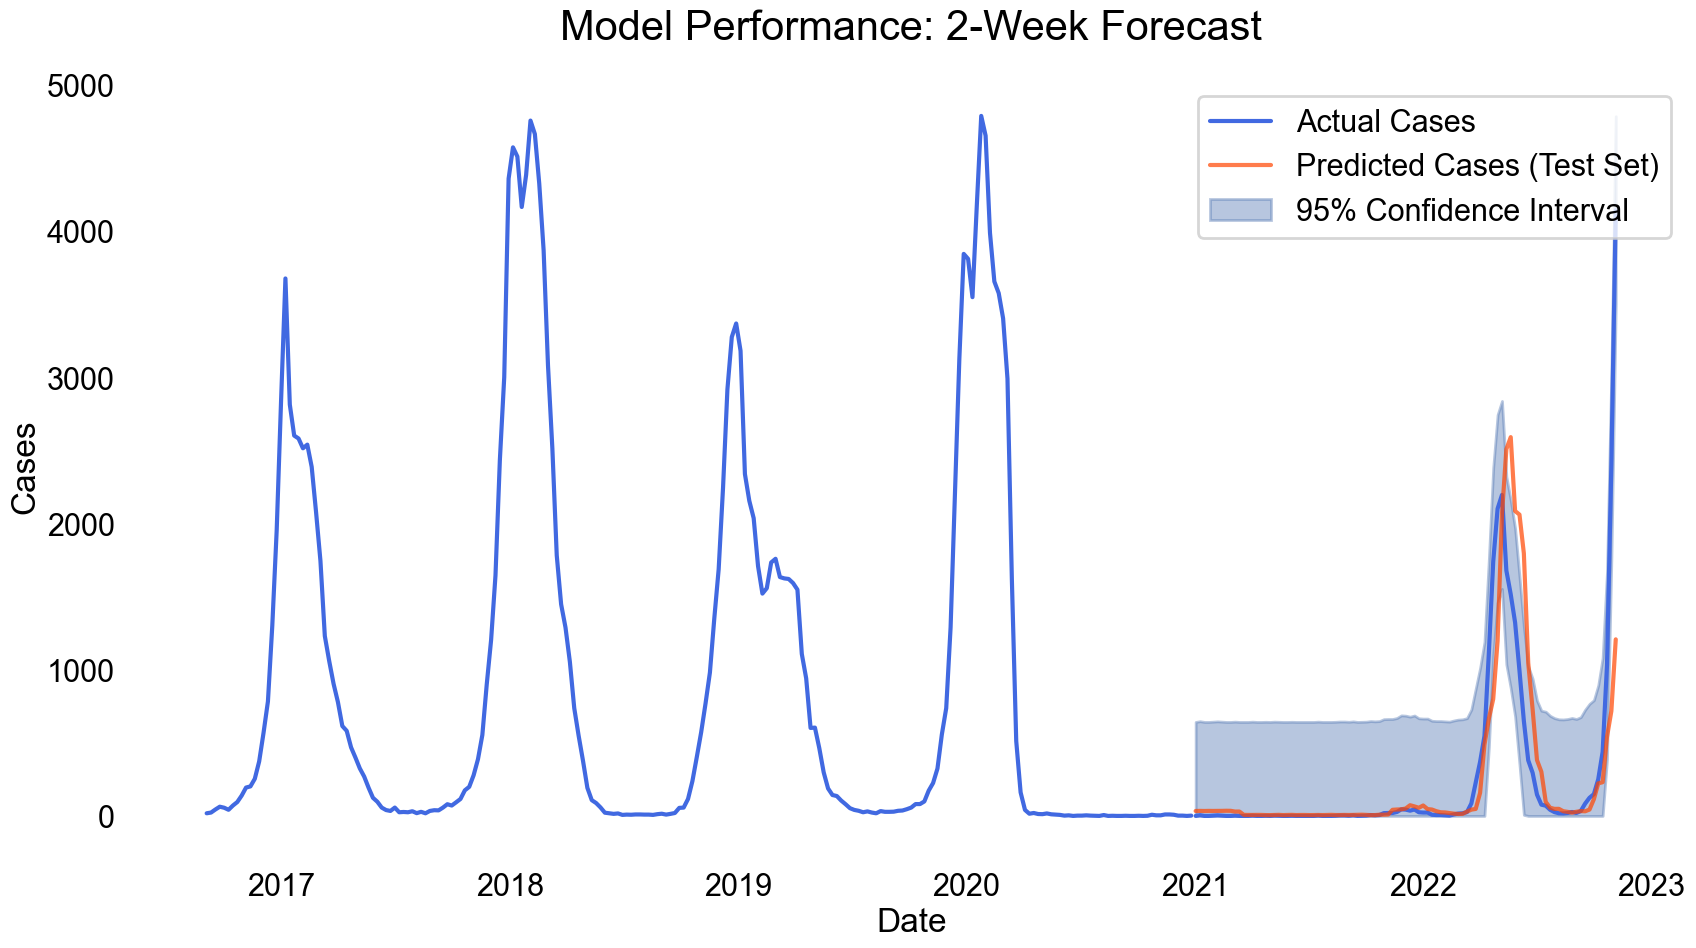

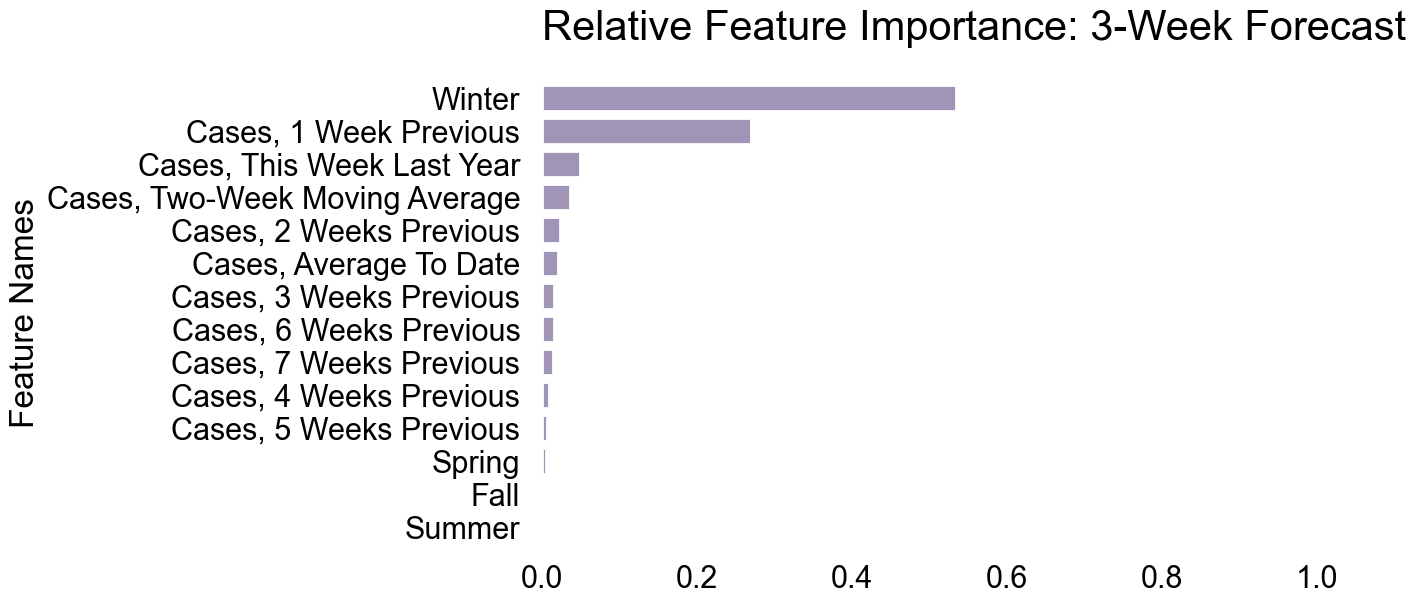

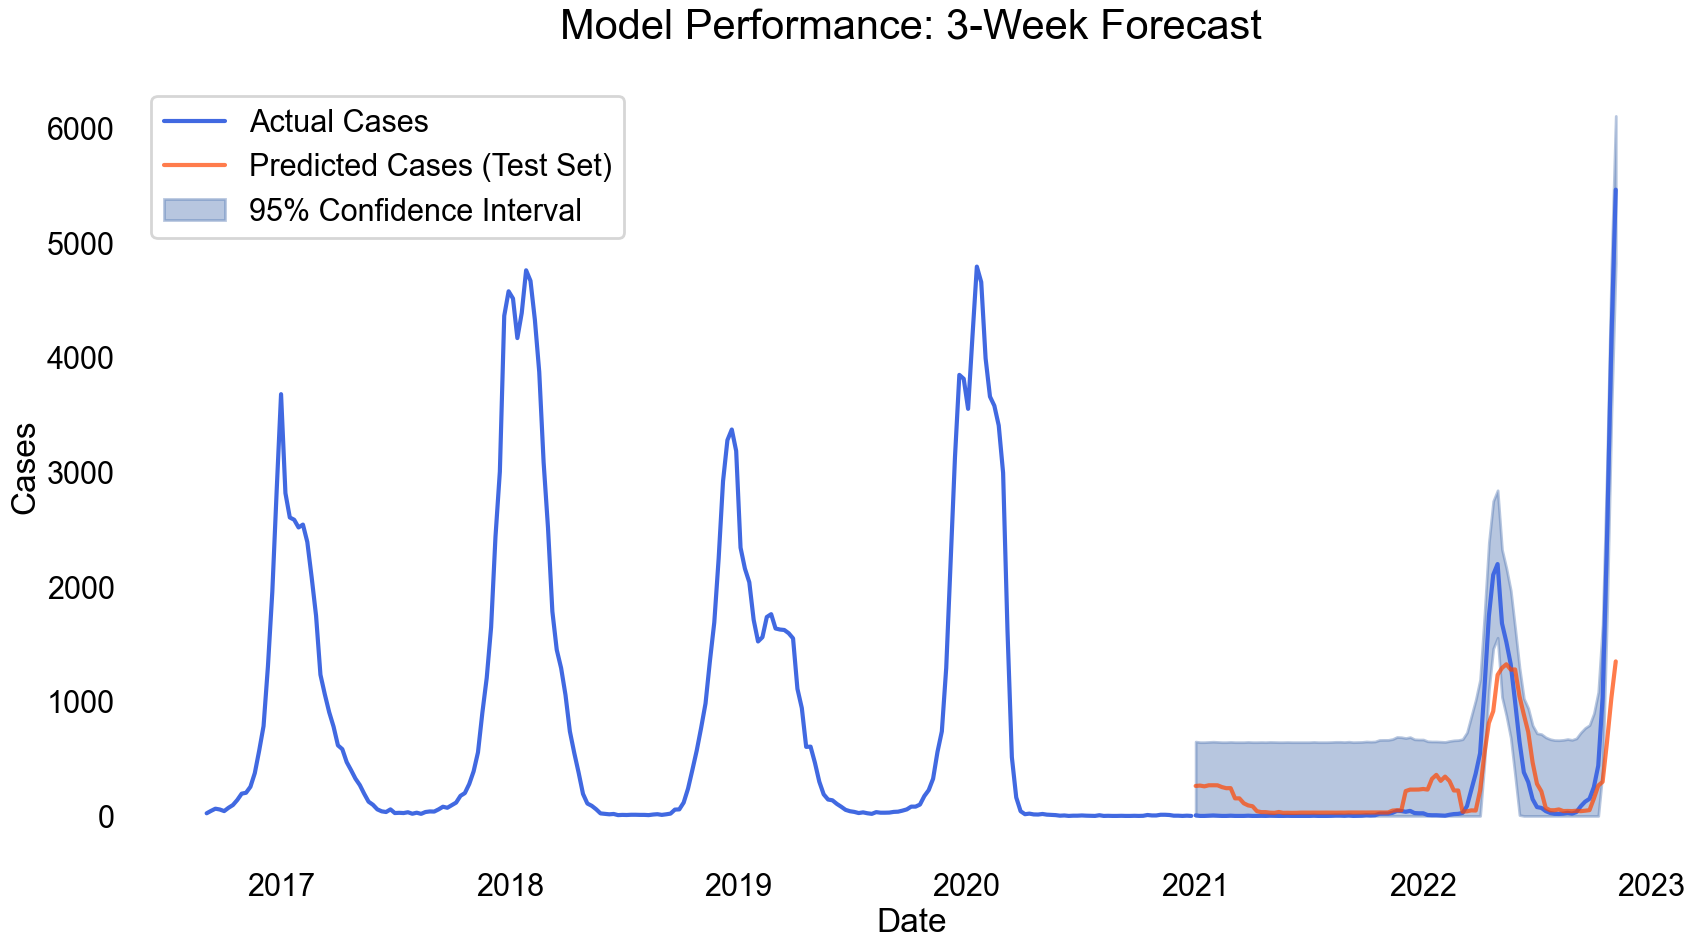

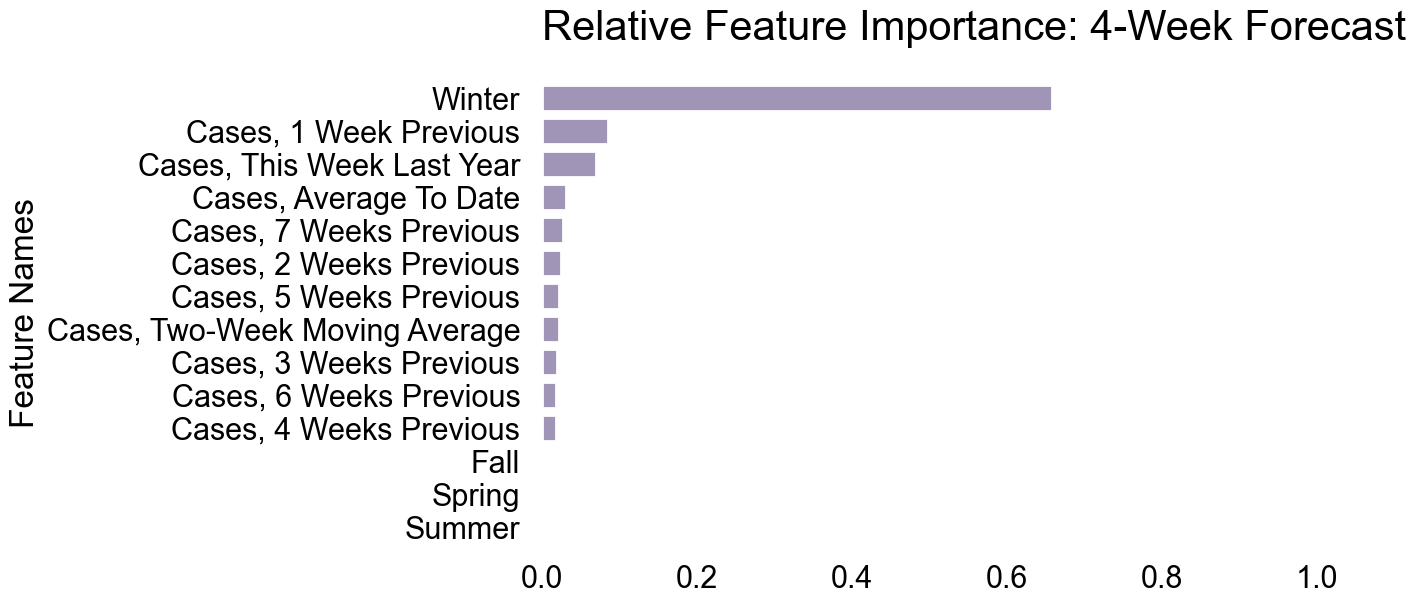

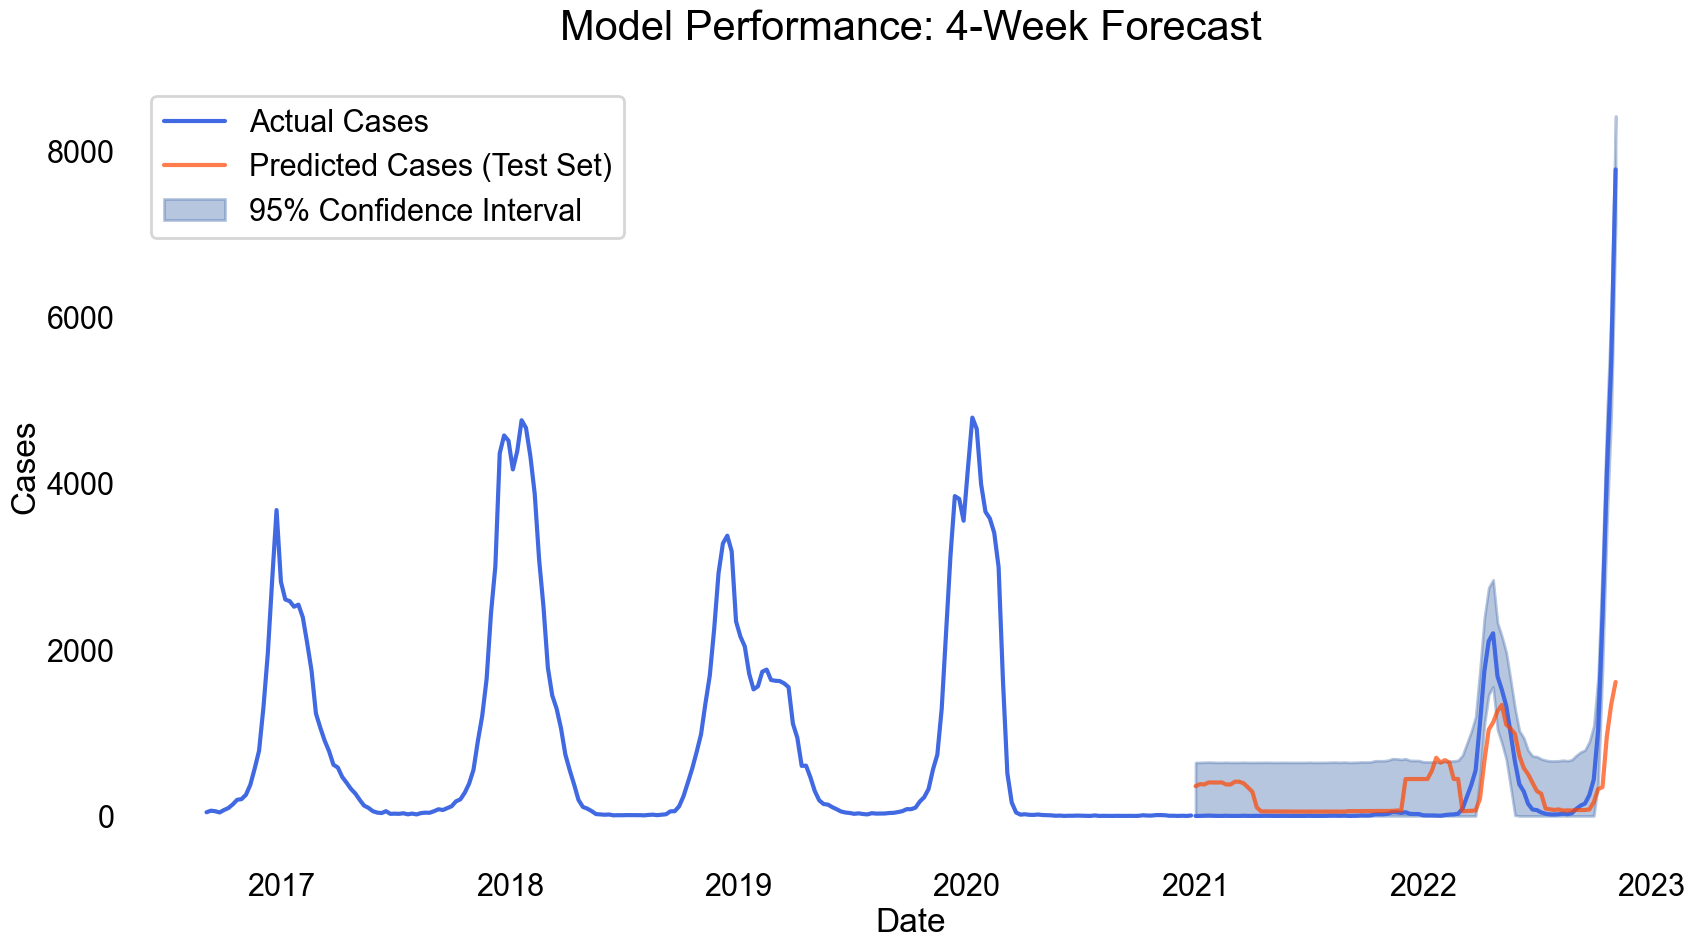

In [50]:
# fit models
weeks = ['y1', 'y2', 'y3', 'y4']
feature_impt_df = []
for week in weeks:
    w = weeks.index(week) + 1

    pipeline_mid.fit(train_X, train_y[week])

    # Record actual values on test set
    predictions_test = pd.DataFrame(test_y[week])
    predictions_test = predictions_test.rename(columns={week:'actual'})
    predictions_train = pd.DataFrame(train_y[week])
    predictions_train = predictions_train.rename(columns={week:'actual'})

    # Predict
    predictions_train['mid'] = pipeline_mid.predict(train_X)
    predictions_test['mid'] = pipeline_mid.predict(test_X)

    dataset = 'Full Dataset'

    # Evaluate
    results_matrix = evaluate_model(train_y=train_y[week], test_y=test_y[week], preds_train=predictions_train['mid'], preds_test=predictions_test['mid'], dataset=dataset, forecast_weeks=w, model='Gradient Boost')

    # get feature importances from the model (referenced https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline)
    importance = pipeline_mid.steps[1][1].feature_importances_
    names = pipeline_mid[:-1].get_feature_names_out()
    col_name = 'Feature Importance'
    df = pd.DataFrame({'Feature Names':names,col_name:importance})
    df = df.sort_values(by=col_name, ascending = False)
    df[['dtype','Feature Names']] = df['Feature Names'].str.split("__",expand=True)
    df = df.drop(columns='dtype')
    df = df.replace({'Feature Names':
{
    'season_Winter':'Winter',
    'season_Fall':'Fall',
    'season_Summer':'Summer',
    'season_Spring':'Spring',
    'this week last year':'Cases, This Week Last Year',
    'two-week moving average':'Cases, Two-Week Moving Average',
    'expanding mean':'Cases, Average To Date',
    't - 1':'Cases, 1 Week Previous',
    't - 2':'Cases, 2 Weeks Previous',
    't - 3':'Cases, 3 Weeks Previous',
    't - 4':'Cases, 4 Weeks Previous',
    't - 5':'Cases, 5 Weeks Previous',
    't - 6':'Cases, 6 Weeks Previous',
    't - 7':'Cases, 7 Weeks Previous',
}})

    # plot feature importances
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(data=df, x=col_name, y='Feature Names', orient='h', color='mediumpurple', saturation=0.3)
    ax.set_title(f'Relative Feature Importance: {w}-Week Forecast', fontsize= 30, pad=30, loc='left')
    ax.set(xlabel=None)
    ax.set_xlim([0.0,1.0])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # plot forecast with 95% confidence interval
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(time_train, predictions_train['actual'], color='royalblue', label='Actual Cases')
    ax.plot(time_test, predictions_test['actual'], color='royalblue')
    ax.plot(time_test, predictions_test['mid'], color='orangered', label='Predicted Cases (Test Set)', alpha=0.7)

    predictions_test['lower_band'] = predictions_test['actual']-bs_band_size
    predictions_test['lower_band_zero'] = predictions_test['lower_band'].apply(lambda x: 0 if x < 0 else x)
    ax.fill_between(time_test, predictions_test['lower_band_zero'], (predictions_test['actual']+bs_band_size), color='b', alpha=.4, label='95% Confidence Interval')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'Model Performance: {w}-Week Forecast', fontsize= 30, pad=30)
    ax.set_xlabel('Date')
    ax.set_ylabel('Cases')
    ax.legend()

# Forecast

In [25]:
# get data
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))
df = df_time_features.drop(columns=['year','month'])

# get dataframe for plotting dates
df_to_plot = df.dropna()

# last row to make prediction on
df_to_predict = df.iloc[-1,5:]
df_to_predict = pd.DataFrame(df_to_predict).T
df_to_plot

# drop nulls and date to prepare for modelling
df = df.drop(columns='Week Ending').dropna()

df_y = df[['y1','y2','y3','y4']]
df_X = df.drop(columns=['y1','y2','y3','y4'])

cat_feats = train_X.dtypes[(train_X.dtypes == 'object')].index.tolist()
num_feats = list(train_X.drop(columns=cat_feats).columns)

In [26]:
# set up pipeline
numeric_transform = Pipeline([('scaling', MinMaxScaler())])

categorical_transform = Pipeline([('one-hot-encode', OneHotEncoder(sparse=False))])

ct = make_column_transformer(
(categorical_transform, cat_feats),
(numeric_transform, num_feats),   
remainder='drop')

mid_model = RandomForestRegressor(random_state=2023)

pipeline_mid = Pipeline(steps=[('preprocessing', ct), 
  ('mid_model', mid_model),
  ])

In [27]:
# fit and predict
trained_model = MultiOutputRegressor(pipeline_mid).fit(df_X, df_y)

test_forecasts = trained_model.predict(df_to_predict)

In [28]:
test_forecasts_extend = np.insert(test_forecasts, 0, 7773)

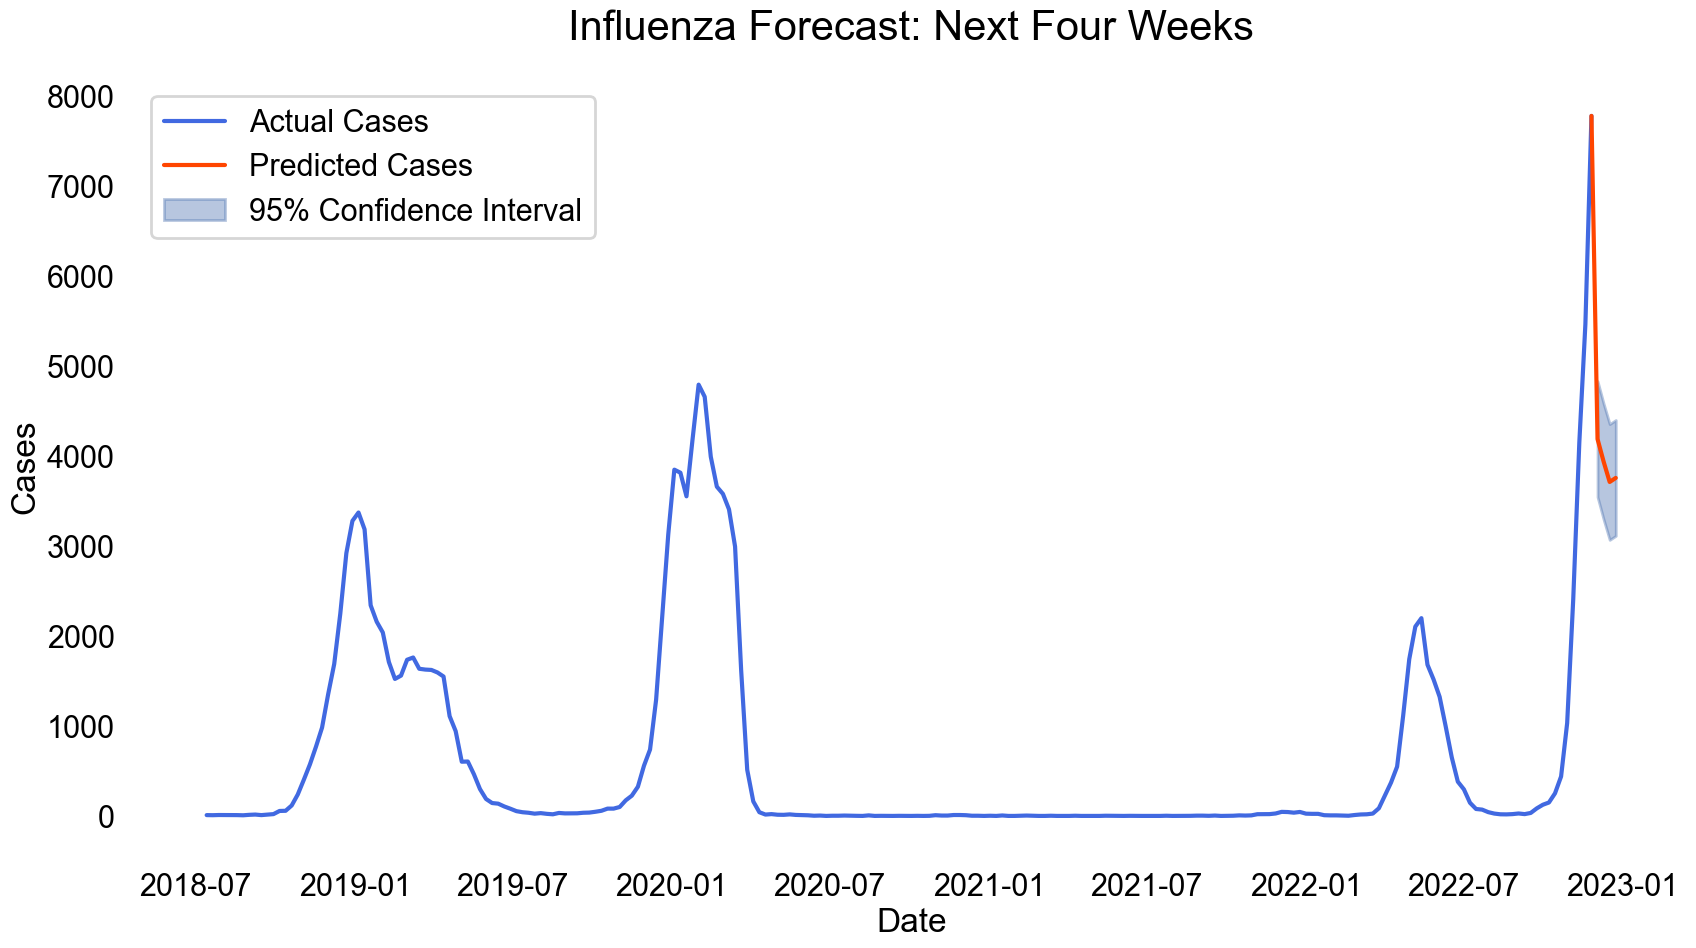

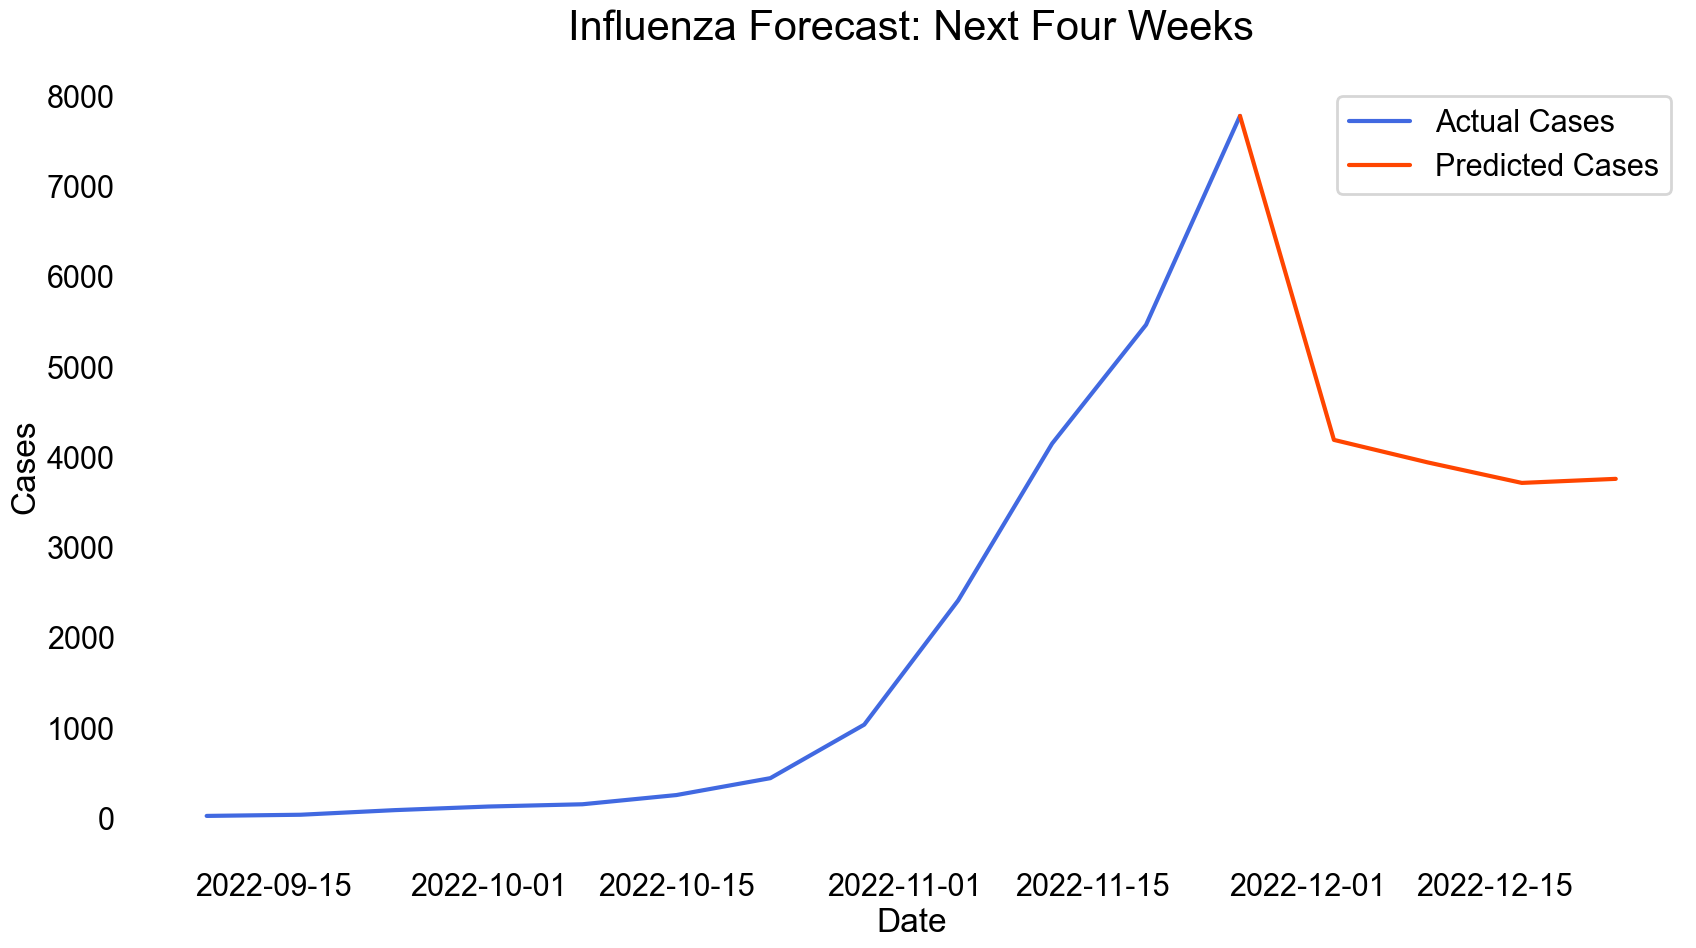

In [47]:
df_flu = pickle.load(open(r"..\data\flu_cases\df_flu_total.pkl", "rb" ))
dates = df_flu.index

from datetime import timedelta
dates = dates + timedelta(weeks=3)

# all dates
fig, ax = plt.subplots()
ax.plot(dates[-233:-4], df_flu[-230:-1].values, color='royalblue', label='Actual Cases')
ax.plot(dates[-5:], test_forecasts_extend.reshape(-1,1), color='orangered', label='Predicted Cases')
# ax.plot(dates[:-4], df_flu[3:-1].values, color='royalblue', label='Actual Cases')
# ax.plot(dates[-5:], test_forecasts_extend.reshape(-1,1), color='orangered', label='Predicted Cases')

# confidence interval
lower_bound = test_forecasts.reshape(-1,1) - bs_band_size
lower_bound_flat = np.reshape(lower_bound, -1)
upper_bound = test_forecasts.reshape(-1,1) + bs_band_size
upper_bound_flat = np.reshape(upper_bound, -1)
ax.fill_between(dates[-4:], lower_bound_flat, upper_bound_flat, color='b', alpha=.4, label='95% Confidence Interval')

ax.set_title(f'Influenza Forecast: Next Four Weeks', fontsize= 30, pad=30)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# zoom plot
fig, ax = plt.subplots()
ax.plot(dates[-16:-4], df_flu.iloc[-13:-1].values, color='royalblue', label='Actual Cases')
ax.plot(dates[-5:], test_forecasts_extend.reshape(-1,1), color='orangered', label='Predicted Cases')

ax.set_title(f'Influenza Forecast: Next Four Weeks', fontsize= 30, pad=30)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)